<a href="https://colab.research.google.com/github/leobi123/mda/blob/main/hurdle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Cell 1: Upload and load new dataset ===

from google.colab import files
uploaded = files.upload()  # 'data_new.csv'

import io
import pandas as pd

# Read the uploaded CSV into a DataFrame
df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))

# Preview
print("Data shape:", df.shape)
print(df.head())


Saving data_new_with_quality_scores.csv to data_new_with_quality_scores.csv
Data shape: (14731, 23)
   projectID  status   startDate     endDate  totalCost  ecMaxContribution  \
0  101116741  SIGNED  2024-02-01  2029-01-31    1499998            1499998   
1  101162875  SIGNED  2025-03-01  2030-02-28    1500000            1500000   
2  101167314  SIGNED  2025-04-01  2031-03-31   11982258           11982258   
3  101072693  SIGNED  2022-08-01  2024-07-31     100000             100000   
4  101172406  SIGNED  2024-07-01  2025-12-31     608440             300000   

   OQI_month_norm country           region  region_code  ... sub_fund_code  \
0        0.000000      NL   Western Europe            1  ...             1   
1        0.000000      IT  Southern Europe            3  ...             1   
2        0.000000      IT  Southern Europe            3  ...             1   
3        0.021259      UA   Eastern Europe            4  ...             4   
4        0.000000      PL   Eastern Europ

In [ ]:
# === Cell 2: Define target, features & split ===

# Target and binary label
y = df['OQI_month_norm']
is_positive = (y > 0).astype(int)

# Feature lists
categorical_features = ['region_code', 'topic_code', 'sub_fund_code']
numeric_features = [
    'ecMaxContribution', 'totalCost', 'organizationCount',
    'countryCount', 'europeanCountryCount', 'countryDiversityIndex',
    'europeanOrganizationRatio', 'geoCentralizationIndex(KM)',
    'crossSectorCollaborationIndex', 'fundingEqualityIndex'
]

# Build feature matrix
X = df[categorical_features + numeric_features]

from sklearn.model_selection import train_test_split

# Classification split (zero vs non-zero)
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X, is_positive, test_size=0.2, random_state=42
)

# Regression split (only positive samples)
mask = (y > 0)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X[mask], y[mask], test_size=0.2, random_state=42
)

# Confirm shapes
print("Classification train/test:", X_cls_train.shape, X_cls_test.shape)
print("Regression train/test:   ", X_reg_train.shape, X_reg_test.shape)


Classification train/test: (11784, 13) (2947, 13)
Regression train/test:    (5348, 13) (1337, 13)


In [ ]:
# === Cell 3: Hurdle Model with Proper Factor Encoding & Evaluation ===

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, mean_squared_error, r2_score
)

# Preprocessor: one-hot encode categorical, standardize numeric
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

# Classification pipeline
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
clf_pipeline.fit(X_cls_train, y_cls_train)

# Regression pipeline
reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])
reg_pipeline.fit(X_reg_train, y_reg_train)

# Classification evaluation
y_cls_pred = clf_pipeline.predict(X_cls_test)
y_cls_proba = clf_pipeline.predict_proba(X_cls_test)[:,1]
print("Classification Metrics:")
print("  Accuracy :", accuracy_score(y_cls_test, y_cls_pred))
print("  Precision:", precision_score(y_cls_test, y_cls_pred))
print("  Recall   :", recall_score(y_cls_test, y_cls_pred))
print("  F1 Score :", f1_score(y_cls_test, y_cls_pred))
print("  ROC AUC  :", roc_auc_score(y_cls_test, y_cls_proba))
print("  Confusion Matrix:\n", confusion_matrix(y_cls_test, y_cls_pred))

# Regression evaluation
y_reg_pred = reg_pipeline.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = mse ** 0.5
print("\nRegression Metrics:")
print("  MSE :", mse)
print("  RMSE:", rmse)
print("  R2  :", r2_score(y_reg_test, y_reg_pred))


Classification Metrics:
  Accuracy : 0.5734645402103834
  Precision: 0.5451388888888888
  Recall   : 0.35280898876404493
  F1 Score : 0.42837653478854026
  ROC AUC  : 0.5899046012583525
  Confusion Matrix:
 [[1219  393]
 [ 864  471]]

Regression Metrics:
  MSE : 0.0002733662345221652
  RMSE: 0.016533790688228914
  R2  : 0.32404120944133485


Top 10 Feature Importances (GradientBoostingRegressor):
                              feature  importance
0           num__fundingEqualityIndex    0.370567
1              num__organizationCount    0.229957
2           num__europeanCountryCount    0.072845
3                      num__totalCost    0.070029
4          num__countryDiversityIndex    0.049606
5                   cat__topic_code_4    0.039581
6  num__crossSectorCollaborationIndex    0.024126
7              num__ecMaxContribution    0.022657
8      num__europeanOrganizationRatio    0.021461
9                cat__sub_fund_code_1    0.020105


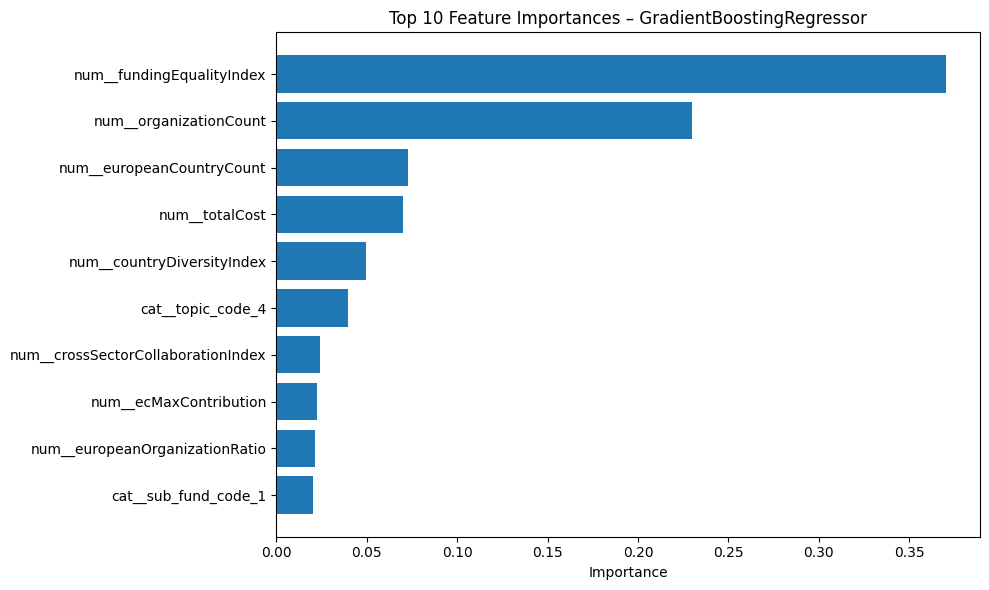

In [ ]:
# === Cell 4: GradientBoostingRegressor Feature Importances ===

import pandas as pd
import matplotlib.pyplot as plt

# 1. Extract the preprocessed feature names
feature_names = reg_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 2. Get the regressor's feature_importances_
importances_reg = reg_pipeline.named_steps['regressor'].feature_importances_

# 3. Build a DataFrame and sort by importance descending
reg_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances_reg
}).sort_values('importance', ascending=False).reset_index(drop=True)

# 4. Display the top 10 most important features
print("Top 10 Feature Importances (GradientBoostingRegressor):")
print(reg_imp_df.head(10))

# 5. Plot the top 10 as a horizontal bar chart
top_n = 10
top_feats = reg_imp_df.head(top_n)
plt.figure(figsize=(10, 6))
plt.barh(top_feats['feature'][::-1], top_feats['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances – GradientBoostingRegressor')
plt.tight_layout()
plt.show()


In [ ]:
# === Cell 4: Try HistGradientBoostingClassifier on the classification step ===

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Build a new pipeline reusing the existing preprocessor
hgb_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('hgb', HistGradientBoostingClassifier(random_state=42))
])

# Train on the same classification split
hgb_clf.fit(X_cls_train, y_cls_train)

# Evaluate on the test set
y_hgb_pred  = hgb_clf.predict(X_cls_test)
y_hgb_proba = hgb_clf.predict_proba(X_cls_test)[:, 1]

print("HistGradientBoostingClassifier Metrics:")
print("  Accuracy :", accuracy_score(y_cls_test, y_hgb_pred))
print("  Precision:", precision_score(y_cls_test, y_hgb_pred))
print("  Recall   :", recall_score(y_cls_test, y_hgb_pred))
print("  F1 Score :", f1_score(y_cls_test, y_hgb_pred))
print("  ROC AUC  :", roc_auc_score(y_cls_test, y_hgb_proba))
print("  Confusion Matrix:\n", confusion_matrix(y_cls_test, y_hgb_pred))


HistGradientBoostingClassifier Metrics:
  Accuracy : 0.6454021038344079
  Precision: 0.5993150684931506
  Recall   : 0.6554307116104869
  F1 Score : 0.6261180679785331
  ROC AUC  : 0.6942272841330471
  Confusion Matrix:
 [[1027  585]
 [ 460  875]]


                           feature  importance_mean  importance_std
0                   num__totalCost         0.081473        0.006981
1  num__geoCentralizationIndex(KM)         0.056396        0.005694
2           num__ecMaxContribution         0.027689        0.005946
3        num__fundingEqualityIndex         0.019206        0.003501
4             cat__sub_fund_code_1         0.010112        0.003254
5             cat__sub_fund_code_3         0.008551        0.001381
6             cat__sub_fund_code_6         0.006820        0.001645
7        num__europeanCountryCount         0.005904        0.001738


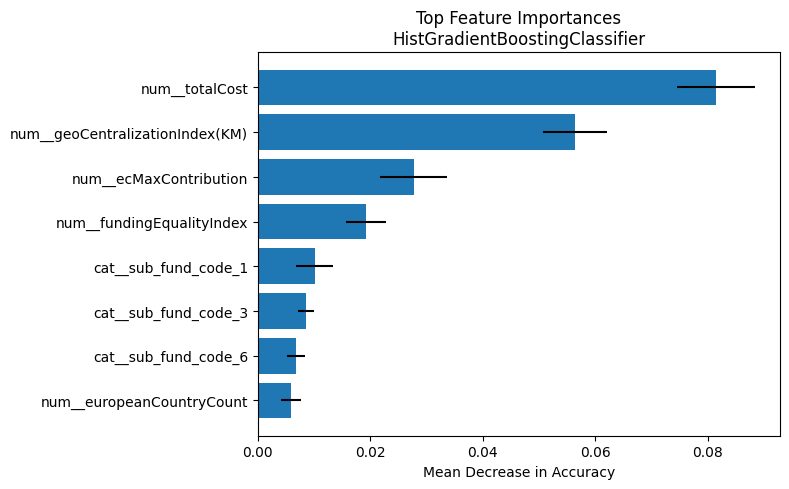

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# 1. Transform the test set using the pipeline’s preprocessor
X_test_trans = hgb_clf.named_steps['preprocessor'].transform(X_cls_test)

# 2. Compute permutation importances
perm_res = permutation_importance(
    hgb_clf.named_steps['hgb'],   # the trained HistGradientBoostingClassifier
    X_test_trans,                 # transformed feature matrix
    y_cls_test,                   # true binary labels
    n_repeats=10,                 # number of shuffles per feature
    random_state=42,
    n_jobs=-1
)

# 3. Build a DataFrame of feature names and their importances, then sort descending
feature_names = hgb_clf.named_steps['preprocessor'].get_feature_names_out()
imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_res.importances_mean,
    'importance_std': perm_res.importances_std
}).sort_values('importance_mean', ascending=False).reset_index(drop=True)

# 4. Display the top 8 features by mean importance
print(imp_df.head(8))

# 5. Extract the top 8 and prepare for horizontal bar plot
top8 = imp_df.head(8)
features = top8['feature'][::-1]
means    = top8['importance_mean'][::-1]
stds     = top8['importance_std'][::-1]

# 6. Plot the top 8 permutation importances as a horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(features, means, xerr=stds)
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Top Feature Importances\nHistGradientBoostingClassifier')
plt.tight_layout()
plt.show()



In [ ]:
# === Cell 6: Logistic Regression Classifier ===

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Build and train pipeline
logreg_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])
logreg_clf.fit(X_cls_train, y_cls_train)

# Evaluate on test set
y_lr_pred  = logreg_clf.predict(X_cls_test)
y_lr_proba = logreg_clf.predict_proba(X_cls_test)[:, 1]

print("Logistic Regression Metrics:")
print("  Accuracy :", accuracy_score(y_cls_test, y_lr_pred))
print("  Precision:", precision_score(y_cls_test, y_lr_pred))
print("  Recall   :", recall_score(y_cls_test, y_lr_pred))
print("  F1 Score :", f1_score(y_cls_test, y_lr_pred))
print("  ROC AUC  :", roc_auc_score(y_cls_test, y_lr_proba))
print("  Confusion Matrix:\n", confusion_matrix(y_cls_test, y_lr_pred))


Logistic Regression Metrics:
  Accuracy : 0.5883949779436716
  Precision: 0.545727136431784
  Recall   : 0.5453183520599251
  F1 Score : 0.5455226676657924
  ROC AUC  : 0.6022994674770681
  Confusion Matrix:
 [[1006  606]
 [ 607  728]]


In [ ]:
# === Cell 7: ExtraTrees Classifier ===

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Build and train pipeline
et_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('et', ExtraTreesClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ))
])
et_clf.fit(X_cls_train, y_cls_train)

# Evaluate on test set
y_et_pred  = et_clf.predict(X_cls_test)
y_et_proba = et_clf.predict_proba(X_cls_test)[:, 1]

print("ExtraTreesClassifier Metrics:")
print("  Accuracy :", accuracy_score(y_cls_test, y_et_pred))
print("  Precision:", precision_score(y_cls_test, y_et_pred))
print("  Recall   :", recall_score(y_cls_test, y_et_pred))
print("  F1 Score :", f1_score(y_cls_test, y_et_pred))
print("  ROC AUC  :", roc_auc_score(y_cls_test, y_et_proba))
print("  Confusion Matrix:\n", confusion_matrix(y_cls_test, y_et_pred))


ExtraTreesClassifier Metrics:
  Accuracy : 0.5856803529012555
  Precision: 0.5414244186046512
  Recall   : 0.5580524344569289
  F1 Score : 0.549612689044633
  ROC AUC  : 0.6056881441622289
  Confusion Matrix:
 [[981 631]
 [590 745]]


In [ ]:
# === Cell 8: AdaBoost Classifier ===

from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Build and train AdaBoost pipeline
ada_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('ada', AdaBoostClassifier(
        n_estimators=100,
        random_state=42
    ))
])
ada_clf.fit(X_cls_train, y_cls_train)

# Evaluate on test set
y_ada_pred  = ada_clf.predict(X_cls_test)
y_ada_proba = ada_clf.predict_proba(X_cls_test)[:, 1]

print("AdaBoostClassifier Metrics:")
print("  Accuracy :", accuracy_score(y_cls_test, y_ada_pred))
print("  Precision:", precision_score(y_cls_test, y_ada_pred))
print("  Recall   :", recall_score(y_cls_test, y_ada_pred))
print("  F1 Score :", f1_score(y_cls_test, y_ada_pred))
print("  ROC AUC  :", roc_auc_score(y_cls_test, y_ada_proba))
print("  Confusion Matrix:\n", confusion_matrix(y_cls_test, y_ada_pred))


AdaBoostClassifier Metrics:
  Accuracy : 0.5965388530709196
  Precision: 0.5695238095238095
  Recall   : 0.44794007490636706
  F1 Score : 0.5014675052410902
  ROC AUC  : 0.6409794053958606
  Confusion Matrix:
 [[1160  452]
 [ 737  598]]


In [ ]:
# === Cell 9: MLP (Neural Network) Classifier ===

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Build and train MLP pipeline
mlp_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(100,),
        max_iter=300,
        random_state=42
    ))
])
mlp_clf.fit(X_cls_train, y_cls_train)

# Evaluate on test set
y_mlp_pred  = mlp_clf.predict(X_cls_test)
y_mlp_proba = mlp_clf.predict_proba(X_cls_test)[:, 1]

print("MLPClassifier Metrics:")
print("  Accuracy :", accuracy_score(y_cls_test, y_mlp_pred))
print("  Precision:", precision_score(y_cls_test, y_mlp_pred))
print("  Recall   :", recall_score(y_cls_test, y_mlp_pred))
print("  F1 Score :", f1_score(y_cls_test, y_mlp_pred))
print("  ROC AUC  :", roc_auc_score(y_cls_test, y_mlp_proba))
print("  Confusion Matrix:\n", confusion_matrix(y_cls_test, y_mlp_pred))


MLPClassifier Metrics:
  Accuracy : 0.5938242280285035
  Precision: 0.5721757322175732
  Recall   : 0.40973782771535583
  F1 Score : 0.47752073330423395
  ROC AUC  : 0.6095791395990743
  Confusion Matrix:
 [[1203  409]
 [ 788  547]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# === Cell 10: HistGradientBoostingRegressor for regression ===

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Build the regression pipeline reusing the existing preprocessor
hgb_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('hgb_reg', HistGradientBoostingRegressor(random_state=42))
])

# Train on the positive-sample training split
hgb_reg.fit(X_reg_train, y_reg_train)

# Predict on the regression test set
y_hgb_pred = hgb_reg.predict(X_reg_test)

# Calculate and print evaluation metrics
mse  = mean_squared_error(y_reg_test, y_hgb_pred)
rmse = mse ** 0.5
r2   = r2_score(y_reg_test, y_hgb_pred)

print("HistGradientBoostingRegressor Metrics:")
print(f"  RMSE: {rmse:.6f}")
print(f"  R2  : {r2:.4f}")


HistGradientBoostingRegressor Metrics:
  RMSE: 0.017020
  R2  : 0.2837


In [ ]:
# === Cell 11: RandomForestRegressor for regression ===

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Build and train the RandomForest regressor pipeline
rf_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('rf_reg', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_reg.fit(X_reg_train, y_reg_train)

# Predict and evaluate
y_rf_pred = rf_reg.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_rf_pred)
rmse = mse ** 0.5
r2 = r2_score(y_reg_test, y_rf_pred)

print("RandomForestRegressor Metrics:")
print(f"  RMSE: {rmse:.6f}")
print(f"  R2  : {r2:.4f}")


RandomForestRegressor Metrics:
  RMSE: 0.016592
  R2  : 0.3193


In [ ]:
# === Cell 12: Ridge Regression with cross-validation ===

from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Build and train the Ridge regression pipeline with internal CV
ridge_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5))
])
ridge_reg.fit(X_reg_train, y_reg_train)

# Predict and evaluate
y_ridge_pred = ridge_reg.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_ridge_pred)
rmse = mse ** 0.5
r2 = r2_score(y_reg_test, y_ridge_pred)

print("RidgeCV Regression Metrics:")
print(f"  RMSE: {rmse:.6f}")
print(f"  R2  : {r2:.4f}")


RidgeCV Regression Metrics:
  RMSE: 0.017020
  R2  : 0.2837


In [ ]:
# === Cell 13: K-Nearest Neighbors Regressor ===

from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Build and train KNN regression pipeline
knn_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(
        n_neighbors=5,
        weights='distance'
    ))
])
knn_reg.fit(X_reg_train, y_reg_train)

# Predict and evaluate
y_knn_pred = knn_reg.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_knn_pred)
rmse = mse ** 0.5
r2  = r2_score(y_reg_test, y_knn_pred)

print("KNN Regressor Metrics:")
print(f"  RMSE: {rmse:.6f}")
print(f"  R2  : {r2:.4f}")


KNN Regressor Metrics:
  RMSE: 0.017305
  R2  : 0.2595


In [ ]:
# === Cell 14: Support Vector Regressor (SVR) ===

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Build and train SVR pipeline
svr_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(
        kernel='rbf',
        C=1.0,
        epsilon=0.01
    ))
])
svr_reg.fit(X_reg_train, y_reg_train)

# Predict and evaluate
y_svr_pred = svr_reg.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_svr_pred)
rmse = mse ** 0.5
r2  = r2_score(y_reg_test, y_svr_pred)

print("SVR Metrics:")
print(f"  RMSE: {rmse:.6f}")
print(f"  R2  : {r2:.4f}")


SVR Metrics:
  RMSE: 0.018357
  R2  : 0.1668
